In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tqdm import tqdm
import re

torch.manual_seed(42)
np.random.seed(42)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define the disaster categories
disaster_categories = {
    0: "No Disaster",
    1: "Earthquake",
    2: "Flood",
    3: "Hurricane",
    4: "Tornado",
    5: "Wildfire"
}

# Define a custom dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, vectorizer=None, tfidf_transformer=None, train=True):
        self.texts = texts
        self.labels = labels
        self.train = train
        
        if train:
            # Create a new vectorizer and transformer if in training mode
            self.vectorizer = CountVectorizer(max_features=5000)
            self.tfidf_transformer = TfidfTransformer()
            
            # Fit and transform the text data
            X_counts = self.vectorizer.fit_transform(self.texts)
            self.X_tfidf = self.tfidf_transformer.fit_transform(X_counts)
        else:
            # Use provided vectorizer and transformer if in test mode
            self.vectorizer = vectorizer
            self.tfidf_transformer = tfidf_transformer
            
            # Transform the text data
            X_counts = self.vectorizer.transform(self.texts)
            self.X_tfidf = self.tfidf_transformer.transform(X_counts)
        
        # Convert sparse matrix to torch tensor
        self.X_tfidf = torch.FloatTensor(self.X_tfidf.toarray())
        self.labels = torch.LongTensor(self.labels)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.X_tfidf[idx], self.labels[idx]
    
    def get_vectorizer(self):
        return self.vectorizer
    
    def get_tfidf_transformer(self):
        return self.tfidf_transformer

# Function to load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='utf-16')
    df['text'] = df['text'].fillna('')
    print(df.head())
    return df['text'].values, df['label'].values

# Load the data
print("Loading data...")
texts, labels = load_data("../../data-preprocessing/combined_dataset.csv")

# # Split the data into training, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (from the 80% train+val)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)



Loading data...
   label                                               text
0      0                      tappanakii with happybirthday
1      0  why you should start paying attention to pro s...
2      0  me before sending a risky text vs me after it ...
3      0                                          capterwin
4      0  lot of blackberry lane winter theme cross stit...


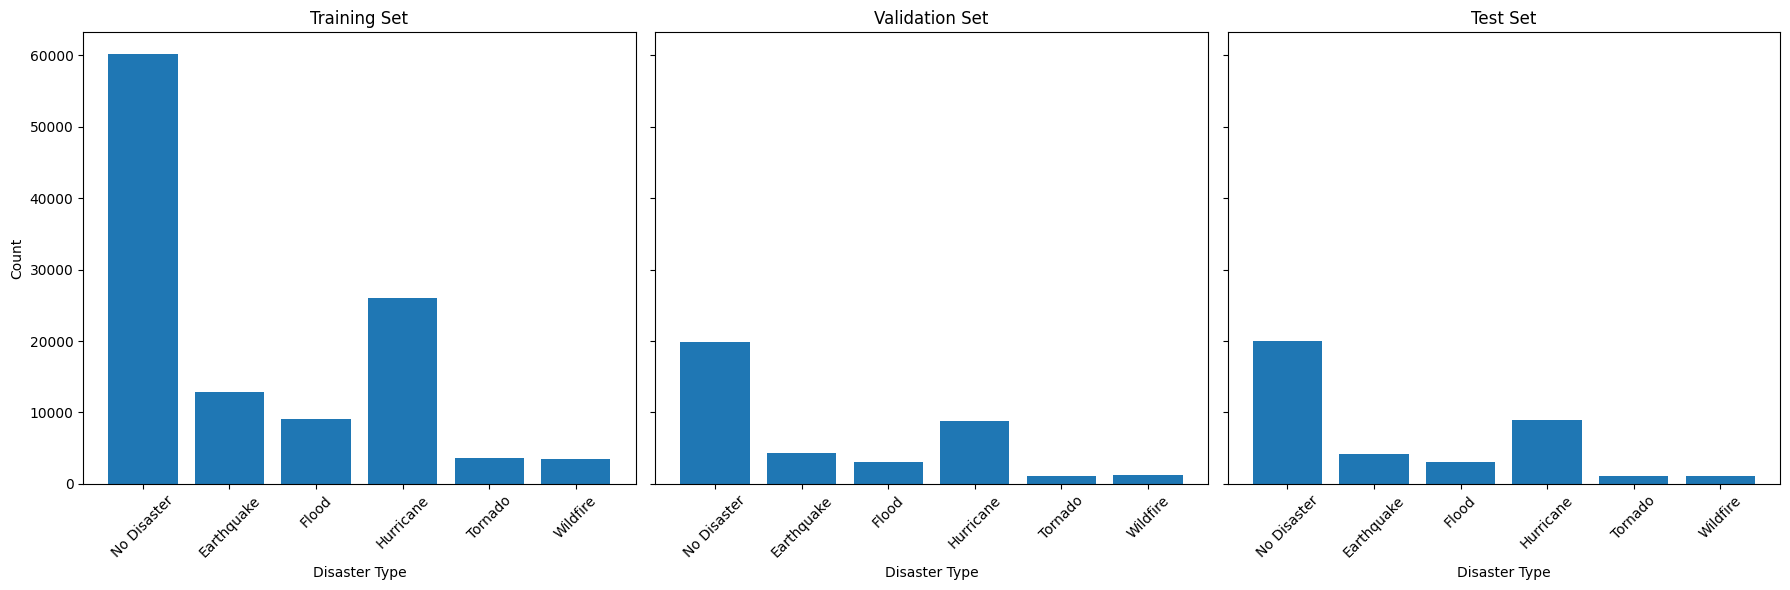

In [3]:

# Show the class distribution of data
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Training set distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(train_counts.index, train_counts.values)
axes[0].set_xticks(train_counts.index)
axes[0].set_xticklabels([disaster_categories[i] for i in train_counts.index], rotation=45)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Disaster Type')
axes[0].set_ylabel('Count')

# Validation set distribution
val_counts = pd.Series(y_val).value_counts().sort_index()
axes[1].bar(val_counts.index, val_counts.values)
axes[1].set_xticks(val_counts.index)
axes[1].set_xticklabels([disaster_categories[i] for i in val_counts.index], rotation=45)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Disaster Type')

# Test set distribution
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[2].bar(test_counts.index, test_counts.values)
axes[2].set_xticks(test_counts.index)
axes[2].set_xticklabels([disaster_categories[i] for i in test_counts.index], rotation=45)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Disaster Type')

plt.tight_layout()
plt.show()


In [4]:

# Create datasets
print("Preparing datasets...")
train_dataset = TweetDataset(X_train, y_train)

# Get the vectorizer and transformer from the training dataset
vectorizer = train_dataset.get_vectorizer()
tfidf_transformer = train_dataset.get_tfidf_transformer()

# Create validation and test datasets using the same vectorizer and transformer
val_dataset = TweetDataset(X_val, y_val, vectorizer, tfidf_transformer, train=False)
test_dataset = TweetDataset(X_test, y_test, vectorizer, tfidf_transformer, train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

Preparing datasets...


In [5]:
# Define the LinearSVM model using PyTorch
class LinearSVM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    
    def forward(self, x):
        return self.fc(x)

# Hinge loss for SVM
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
    
    def forward(self, outputs, labels):
        num_samples = outputs.size(0)
        corrects = outputs.gather(1, labels.view(-1, 1))
        
        # Margin ranking loss
        margin = 1.0
        outputs_margin = outputs - corrects + margin
        outputs_margin[outputs_margin < 0] = 0
        
        # Zero out the correct label
        outputs_margin.scatter_(1, labels.view(-1, 1), 0)
        
        loss = outputs_margin.sum() / num_samples
        return loss
    
# Create model, loss function, and optimizer
input_dim = train_dataset.X_tfidf.shape[1]  # Number of features
output_dim = len(disaster_categories)  # Number of classes

model = LinearSVM(input_dim, output_dim).to(device)

criterion = HingeLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [6]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validate the model
        val_acc = evaluate_model(model, val_loader)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model, "linearsvm_model.pt")
    
    return train_losses, val_accuracies

# Function to evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total
# Ensure labels are within the correct range
assert all(0 <= label < output_dim for label in y_train), "Labels are out of range"

# Train the model
print("Training model...")
train_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

# Load the best model
model = torch.load("linearsvm_model.pt", weights_only=False)

# Evaluate the model on the test set
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Training model...


Epoch 1/10:   0%|          | 0/1800 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 1800/1800 [00:02<00:00, 602.38it/s]


Epoch 1/10, Loss: 1.3263, Validation Accuracy: 0.8271


Epoch 2/10: 100%|██████████| 1800/1800 [00:02<00:00, 639.59it/s]


Epoch 2/10, Loss: 0.6166, Validation Accuracy: 0.8931


Epoch 3/10: 100%|██████████| 1800/1800 [00:02<00:00, 651.34it/s]


Epoch 3/10, Loss: 0.4485, Validation Accuracy: 0.9173


Epoch 4/10: 100%|██████████| 1800/1800 [00:02<00:00, 650.74it/s]


Epoch 4/10, Loss: 0.3732, Validation Accuracy: 0.9316


Epoch 5/10: 100%|██████████| 1800/1800 [00:02<00:00, 659.93it/s]


Epoch 5/10, Loss: 0.3287, Validation Accuracy: 0.9342


Epoch 6/10: 100%|██████████| 1800/1800 [00:02<00:00, 655.51it/s]


Epoch 6/10, Loss: 0.2990, Validation Accuracy: 0.9399


Epoch 7/10: 100%|██████████| 1800/1800 [00:02<00:00, 644.76it/s]


Epoch 7/10, Loss: 0.2773, Validation Accuracy: 0.9416


Epoch 8/10: 100%|██████████| 1800/1800 [00:02<00:00, 649.36it/s]


Epoch 8/10, Loss: 0.2607, Validation Accuracy: 0.9449


Epoch 9/10: 100%|██████████| 1800/1800 [00:02<00:00, 654.09it/s]


Epoch 9/10, Loss: 0.2475, Validation Accuracy: 0.9455


Epoch 10/10: 100%|██████████| 1800/1800 [00:02<00:00, 651.24it/s]


Epoch 10/10, Loss: 0.2366, Validation Accuracy: 0.9490
Test Accuracy: 0.9475


Generating predictions...

Classification Report:
              precision    recall  f1-score   support

 No Disaster       0.93      0.99      0.96     19947
  Earthquake       0.97      0.91      0.94      4253
       Flood       0.94      0.88      0.91      3010
   Hurricane       0.98      0.90      0.94      8876
     Tornado       0.92      0.91      0.92      1155
    Wildfire       0.97      0.87      0.92      1153

    accuracy                           0.95     38394
   macro avg       0.95      0.91      0.93     38394
weighted avg       0.95      0.95      0.95     38394


Confusion Matrix:


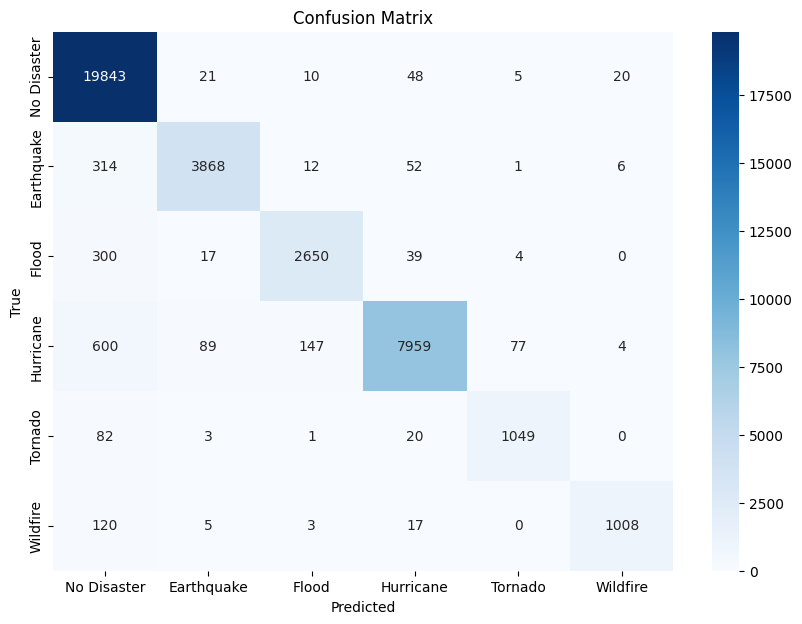

Model saved as 'tweet_disaster_classifier.pt'


In [7]:
import seaborn as sns

# Function to make predictions with the model
def predict(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

# Make predictions on the test set
print("Generating predictions...")
predictions, true_labels = predict(model, test_loader)

# Print classification report
print("\nClassification Report:")
print(classification_report(
    true_labels, 
    predictions, 
    target_names=[disaster_categories[i] for i in range(len(disaster_categories))]
))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predictions)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[disaster_categories[i] for i in range(len(disaster_categories))], yticklabels=[disaster_categories[i] for i in range(len(disaster_categories))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model and preprocessing components
torch.save(model, "tweet_disaster_classifier.pt")

print("Model saved as 'tweet_disaster_classifier.pt'")

In [8]:
# Testing
# Function to classify new tweets
def classify_tweet(tweet_text, model_path="tweet_disaster_classifier.pt"):
    # Load the saved model
    model = torch.load(model_path, weights_only=False)
    model.to(device)
    model.eval()
    
    # Compute class weights
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()
    
    
    # Preprocess the tweet text
    X_counts = vectorizer.transform([tweet_text])
    X_tfidf = tfidf_transformer.transform(X_counts)
    X_tfidf = torch.FloatTensor(X_tfidf.toarray()).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(X_tfidf)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
    return {
        'text': tweet_text,
        'predicted_class': predicted_class.item(),
        'disaster_type': disaster_categories[predicted_class.item()],
        'confidence': confidence.item() * 100,
        'probabilities': {disaster_categories[i]: prob.item() * 100 for i, prob in enumerate(probabilities[0])}
    }


In [9]:
# Test with 10 example tweets
example_tweets = [
    "Earthquake shakes the city center, causing widespread panic.",
    "Wildfire spreads rapidly, threatening homes and wildlife.",
    "Heavy rain causing severe flooding in downtown area. Roads are impassable!",
    "Tornado spotted near the outskirts of town. Seek shelter immediately!",
    "Hurricane approaching the coast, residents urged to evacuate.",
    "No disaster here, just a beautiful sunny day at the beach.",
    "Flood waters rising quickly, residents advised to move to higher ground.",
    "Wildfire smoke causing poor air quality in the region.",
    "Earthquake aftershocks felt throughout the night.",
    "Tornado warning issued for the county, take cover now!"
]

for tweet in example_tweets:
    result = classify_tweet(tweet)
    print(f"Tweet: '{tweet}'")
    print(f"Predicted disaster category: {result['disaster_type']} (ID: {result['predicted_class']})")
    print(f"Confidence: {result['confidence']:.2f}%")
    print("Probabilities:")
    for category, probability in result['probabilities'].items():
        print(f"  {category}: {probability:.2f}%")
    print("\n")

Tweet: 'Earthquake shakes the city center, causing widespread panic.'
Predicted disaster category: Earthquake (ID: 1)
Confidence: 45.19%
Probabilities:
  No Disaster: 15.87%
  Earthquake: 45.19%
  Flood: 9.48%
  Hurricane: 15.60%
  Tornado: 6.86%
  Wildfire: 7.01%


Tweet: 'Wildfire spreads rapidly, threatening homes and wildlife.'
Predicted disaster category: Wildfire (ID: 5)
Confidence: 48.45%
Probabilities:
  No Disaster: 16.69%
  Earthquake: 8.43%
  Flood: 8.82%
  Hurricane: 12.14%
  Tornado: 5.46%
  Wildfire: 48.45%


Tweet: 'Heavy rain causing severe flooding in downtown area. Roads are impassable!'
Predicted disaster category: Flood (ID: 2)
Confidence: 44.37%
Probabilities:
  No Disaster: 7.94%
  Earthquake: 7.71%
  Flood: 44.37%
  Hurricane: 27.80%
  Tornado: 6.61%
  Wildfire: 5.56%


Tweet: 'Tornado spotted near the outskirts of town. Seek shelter immediately!'
Predicted disaster category: Tornado (ID: 4)
Confidence: 50.99%
Probabilities:
  No Disaster: 8.42%
  Earthquake: 8.1